In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

img_path = 'starrycat.jpg'
img = Image.open(img_path).convert('L')
A = np.array(img, dtype=np.float64)


For the above codeblock, I am simply importing needed libraries and loading my image of interest as grayscale and converting it into a numpy array.

In [197]:
def decompose_image(A: np.array):
    blocks = []
    for i in range(0, 32):
        blocks.append([])
        for j in range(0, 32):
            (x, y) = (i, j)
            (x, y) = (x * 8, y * 8)
            blocks[i].append(A[x:x+8, y:y+8])
    return blocks

def combine_blocks(blocks) -> np.array:
    combined = np.zeros((256, 256))
    for i in range(0, 32):
        for j in range(0, 32):
            combined[i*8:i*8+8, j*8:j*8+8] = blocks[i][j]
    return combined

def compress_block(block, k: int) -> np.array:
    U, S, VT = np.linalg.svd(block, full_matrices=False)
    block_k = U[:, :k] @ np.diag(S[:k]) @ VT[:k, :]
    return block_k

def process_image(A: np.array, k: int) -> np.array:
    blocks = decompose_image(A)
    for i in range(0, 32):
        for j in range(0, 32):
            blocks[i][j] = compress_block(blocks[i][j], k)
    combined = combine_blocks(blocks)
    return combined



For the above codeblock, I have defined the following functions:

- decompose_image(A: np.array)
    This function iterates over the image and breaks it into 8x8 blocks for processing.

- combine_blocks(blocks) -> np.array
    This function takes the blocks and converts them back into a single 256x256 numpy array.

- compress_block(block, k: int) -> np.array
    This function applies blockwise SVD on the given block

- process_image(A: np.array, k: int) -> np.array
    This function is a macro for decomposing, performing SVD, and recombining the image.

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

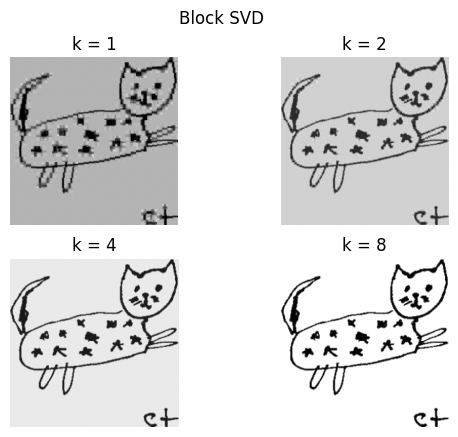

In [198]:
B1 = process_image(A, 1)
B2 = process_image(A, 2)
B3 = process_image(A, 4)
B4 = process_image(A, 8)

fig, axes = plt.subplots(2, 2)
fig.suptitle('Block SVD')

axes[0, 0].imshow(B1, cmap='gray')
axes[0, 0].set_title('k = 1')
axes[0, 0].axis('off')

axes[0, 1].imshow(B2, cmap='gray')
axes[0, 1].set_title('k = 2')
axes[0, 1].axis('off')

axes[1, 0].imshow(B3, cmap='gray')
axes[1, 0].set_title('k = 4')
axes[1, 0].axis('off')

axes[1, 1].imshow(B4, cmap='gray')
axes[1, 1].set_title('k = 8')
axes[1, 1].axis('off')

For the above codeblock, I performed block based SVD for k = 1, k = 2, k = 4, and k = 8. The line quality of the cat drawing increases as k increases. The white level of the background also increases as k increases.

<Axes: title={'center': 'PSNR'}, xlabel='k', ylabel='PSNR'>

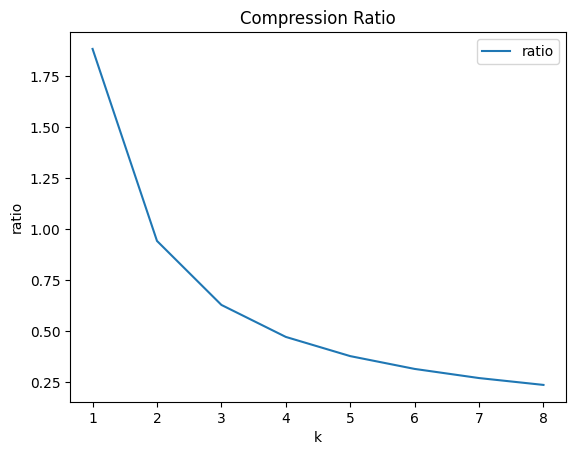

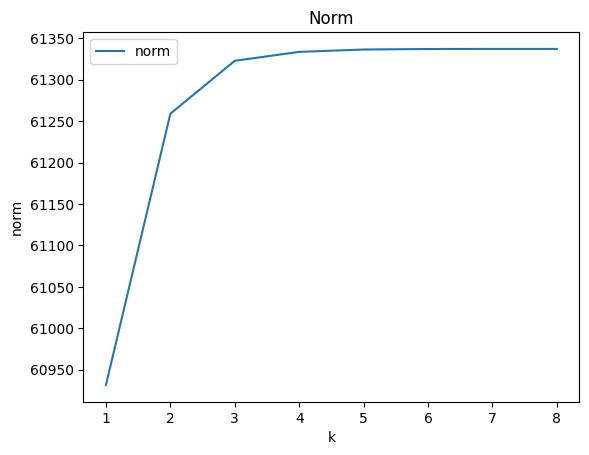

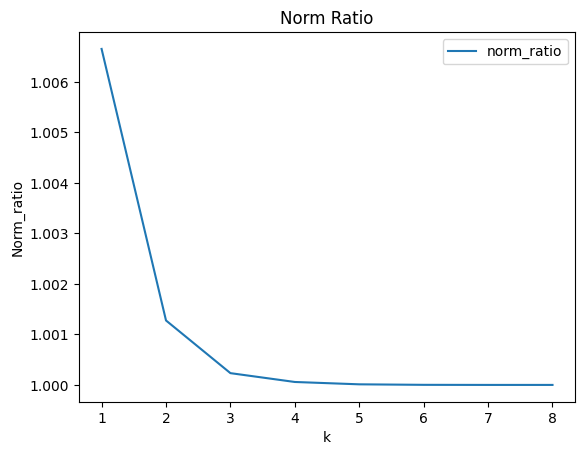

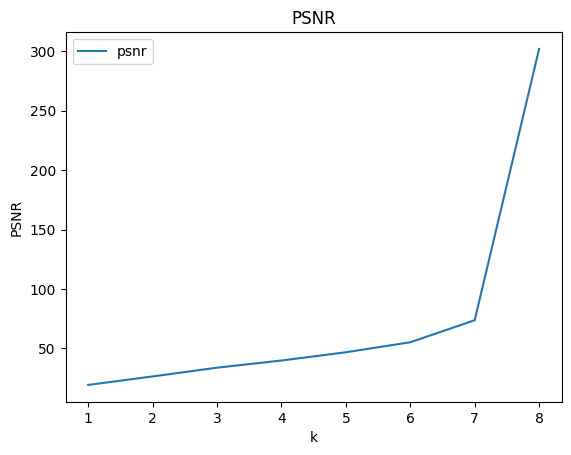

In [199]:
from IPython.display import clear_output
ratio_table: pd.DataFrame = pd.DataFrame(columns=['k', 'ratio'])
norm_table: pd.DataFrame = pd.DataFrame(columns=['k', 'norm'])
norm_ratio: pd.DataFrame = pd.DataFrame(columns=['k', 'norm_ratio'])
psnr_table: pd.DataFrame = pd.DataFrame(columns=['k', 'psnr'])

for i in range(0, 8):
    k = i + 1

    B = process_image(A, k)

    A_norm = np.linalg.norm(A, ord='fro')
    B_norm = np.linalg.norm(B, ord='fro')
    norm_table = pd.concat([norm_table, pd.DataFrame({'k': [k], 'norm': [B_norm]})])
    norm_ratio = pd.concat([norm_ratio, pd.DataFrame({'k': [k], 'norm_ratio': [A_norm / B_norm]})])
    ratio = 32 / (k * (8 + 8 + 1)) 
    ratio_table = pd.concat([ratio_table, pd.DataFrame({'k': [k], 'ratio': [ratio]})])
    R = 255
    mse = np.mean((A - B) ** 2)
    psnr = 10 * np.log10(R ** 2 / mse)
    psnr_table = pd.concat([psnr_table, pd.DataFrame({'k': [k], 'psnr': [psnr]})])

clear_output()

ratio_table.plot(x='k', y='ratio', kind='line', title='Compression Ratio', xlabel='k', ylabel='ratio')
norm_table.plot(x='k', y='norm', kind='line', title='Norm', xlabel='k', ylabel='norm')
norm_ratio.plot(x='k', y='norm_ratio', kind='line', title='Norm Ratio', xlabel='k', ylabel='Norm_ratio')
psnr_table.plot(x='k', y='psnr', kind='line', title='PSNR', xlabel='k', ylabel='PSNR')


For the above codeblock, I performed block-wise SVD and calculated a few different metrics for plotting.

- Compression Ratio
  As the value of k increases, we see the comrpession ratio get smaller and smaller as the amount of data in the new image increases (for k * (8 + 8 + 1))

- Norm
  Here I am plotting the frobenius norm of the new image generated based on K. We see that the norm increases up to an upper limit where the increase in qualtiy is not as high.

- Norm Ratio
  I also plotted the ratio of the original image norm to the new image to show that as the images get closer in appearance, the norm ratio approaches 1.

- PSNR
  I lastly plotted peak signal to noise ratio. We see between 7 and 8 the PSNR skyrockets, perhaps due to increasing white levels in the background of the image.